In [80]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pickle
import numpy as np
import importlib
import models
importlib.reload(models)
import networkx as nx
from gerrychain import Graph

In [81]:
df = pd.read_csv("csv_files/model_avgs.csv")

In [82]:
df.rename( columns={'Unnamed: 0':'Model_Type'}, inplace=True )
df["Model_Type"] = df["Model_Type"].str.replace("Model", "").str.strip()

In [83]:
# Add Avg ST Cons to dataset
avg_st_cons = []

for model in df["Model_Type"]:
    with open(f'pkls/tree_const_m{model}.pkl', 'rb') as f:
        tree_const = pickle.load(f)
    avg_st_cons.append(np.mean(tree_const).round(2))

df["avg_st_con"] = avg_st_cons

In [84]:
model_colors = {
    "2": "darkgreen",
    "3": "cornflowerblue",
    "4": "indigo",
    "4b": "tab:purple",
    "5": "deeppink",
    "5b": "tab:pink",
    "6": "tab:orange",
    "7": "brown",
    "8": "tab:cyan",
    "9": "lightcoral",
    "9b": "indianred",
    "10": "tab:olive",
    "10b": "gold",
    "11": "springgreen",
    "11b": "forestgreen",
    "11c": "yellowgreen",
    "12": "darkcyan",
    "12b": "darkturquoise"
}
colors = df["Model_Type"].map(model_colors)

In [85]:
# Real Data
rd_avg_deg = 5.4
with open(f'pkls/tree_const_real.pkl', 'rb') as f:
        tree_const = pickle.load(f)
        rd_st_cons = np.mean(tree_const)

/var/folders/2w/nf45dfcn5c9cqf954vr1lz3r0000gn/T/ipykernel_39190/3373584458.py:4: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate(f'Real Data', (rd_st_cons, rd_avg_deg), textcoords="offset pixels")


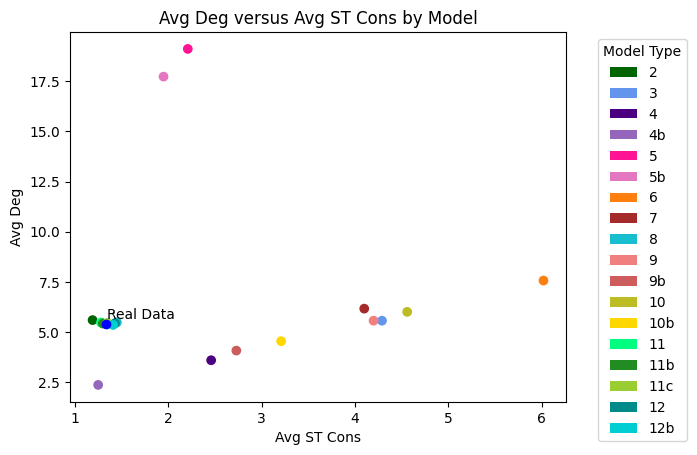

In [86]:
plt.scatter(x=df["avg_st_con"], y=df["avg_deg"], c=colors)

plt.scatter(x=rd_st_cons, y=rd_avg_deg, c="blue")
plt.annotate(f'Real Data', (rd_st_cons, rd_avg_deg), textcoords="offset pixels")

plt.xlabel("Avg ST Cons")
plt.ylabel("Avg Deg")
legend_elements = [Patch(facecolor=color, label=label) for label, color in model_colors.items()]
plt.legend(handles=legend_elements, title="Model Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Avg Deg versus Avg ST Cons by Model")
plt.savefig(f'imgs/av_deg_st_cons_by_model.png')

/var/folders/2w/nf45dfcn5c9cqf954vr1lz3r0000gn/T/ipykernel_39190/2166518893.py:22: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate("Real Data", (rd_st_cons, rd_avg_deg), textcoords="offset pixels")


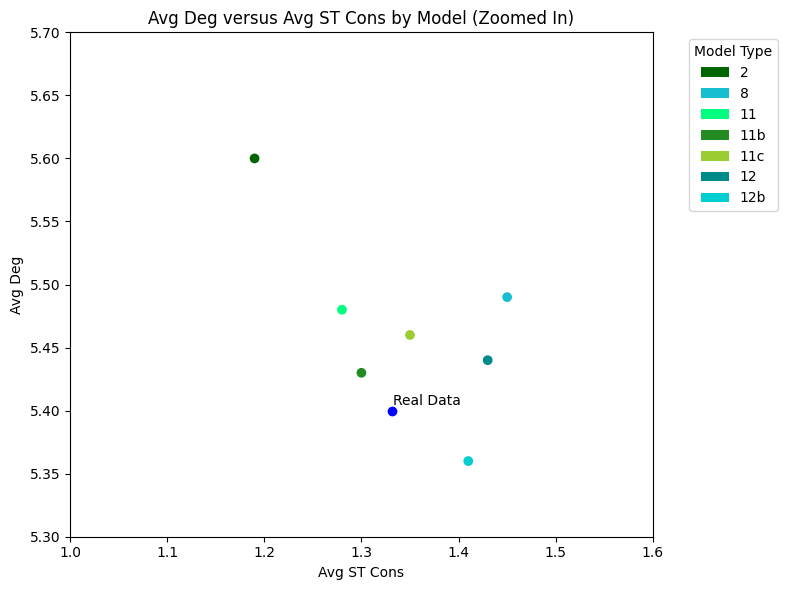

In [87]:
# Define zoomed in region
x_min, x_max = 1, 1.6
y_min, y_max = 5.3, 5.7

# Filter df to just the visible points
visible_df = df[(df["avg_st_con"] >= x_min) & (df["avg_st_con"] <= x_max) &
                (df["avg_deg"] >= y_min) & (df["avg_deg"] <= y_max)]

# Also filter the colors array accordingly
visible_colors = [color for i, color in enumerate(colors) if df.index[i] in visible_df.index]

# Create new model_colors dictionary just for the visible models
visible_model_types = visible_df["Model_Type"].unique()
visible_model_colors = {label: model_colors[label] for label in visible_model_types}

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x=visible_df["avg_st_con"], y=visible_df["avg_deg"], 
            c=visible_colors)

plt.scatter(x=rd_st_cons, y=rd_avg_deg, c="blue")
plt.annotate("Real Data", (rd_st_cons, rd_avg_deg), textcoords="offset pixels")

plt.xlabel("Avg ST Cons")
plt.ylabel("Avg Deg")
legend_elements = [Patch(facecolor=color, label=label) for label, color in visible_model_colors.items()]
plt.legend(handles=legend_elements, title="Model Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Avg Deg versus Avg ST Cons by Model (Zoomed In)")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.savefig("imgs/av_deg_st_cons_by_model_zoomed_in.png")

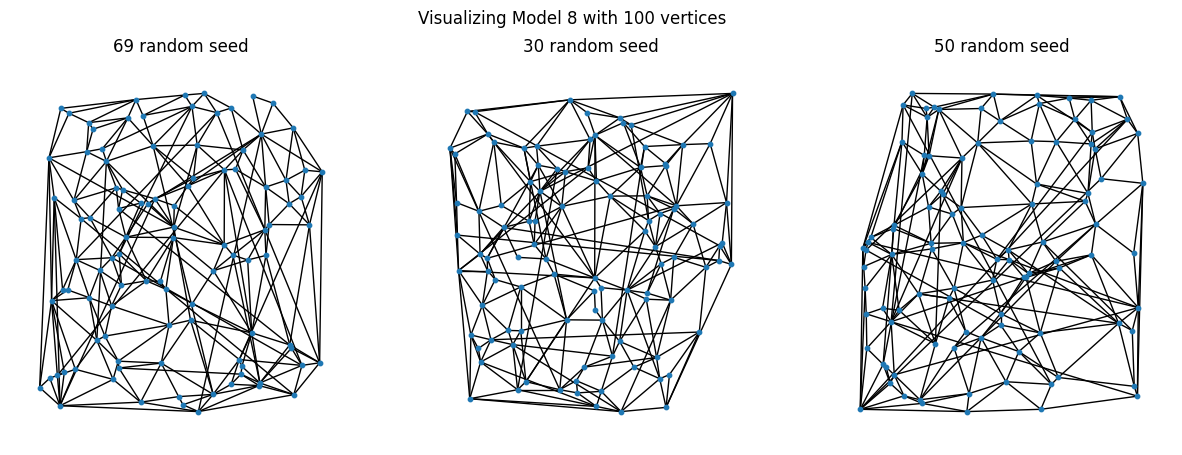

In [88]:
model = "8"
n = 100
rs = [69, 30, 50]

fig, ax = plt.subplots(1, len(rs), figsize=(15, 5))

if model == "8":
    for i in range(len(rs)):
        G = models.model_eight(n, rs[i])
        node_locations = {v: (float(G.nodes()[v]['x_axis']), float(G.nodes()[v]['y_axis'])) for v in G.nodes()}
        nx.draw(G, node_size = 10, pos = node_locations, ax=ax[i])
        ax[i].set_title(f'{rs[i]} random seed')
elif model == "11c":
    for i in range(len(rs)):
        G = models.model_two_rand_removal(n, rs[i], scaling_factor=14, remove_prob=0.6)
        node_locations = {v: (float(G.nodes()[v]['x_axis']), float(G.nodes()[v]['y_axis'])) for v in G.nodes()}
        nx.draw(G, node_size = 10, pos = node_locations, ax=ax[i])
        ax[i].set_title(f'{rs[i]} random seed')

fig.suptitle(f"Visualizing Model {model} with {n} vertices")
plt.savefig(f'imgs/visualize_model{model}.png')

In [89]:
df.loc[-1] = ["Real Data", 0.72, 0.89, 5.42, 5.00, 24.28,rd_st_cons]
df.index = df.index + 1
df.sort_index(inplace=True) 
df.to_csv("csv_files/model_avgs_st_cons.csv", index=False)